In [1]:
from collections import Counter, defaultdict
import csv
from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.signal import convolve2d
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale

import seaborn as sns

from collections import Counter, OrderedDict, defaultdict
from itertools import product, combinations
from rdflib.namespace import XSD, Namespace
from rdflib import URIRef

from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

from scipy.interpolate import Akima1DInterpolator, CubicHermiteSpline

import IPython

In [2]:
df = pd.read_csv('Finaly_together.csv')
df = df.rename(columns={'occupations': 'occupation'})

display(df)

,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,outdegree,Degree,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering
0,http://ldf.fi/coco/actors/p2380574174453621727,"Carlström, Hulda",NaN,NaN,NaN,1914-01-01,1914,Female,1914-12-31,Person,...,1,1,0,5,5,1,1.000000,1.000000,0.0,0.00
1,http://ldf.fi/coco/actors/p1463334693827000551,"Broman, Johan Henrik",NaN,NaN,NaN,1879-01-01,1879,Male,1879-12-31,Person,...,1,1,0,1,1,11,0.160415,0.165002,0.0,0.00
2,http://ldf.fi/coco/actors/p3334862743010934343,"Datta, Rena",NaN,NaN,NaN,1913-01-01,1913-1930,Female,1930-12-31,Person,...,1,1,0,9,9,1,1.000000,1.000000,0.0,0.00
3,http://ldf.fi/coco/actors/p3370516753270868332,"Bockström, Bertel",NaN,NaN,NaN,1898-01-01,1898,Male,1898-12-31,Person,...,1,1,0,1,1,10,0.199762,0.208582,0.0,0.00
4,http://ldf.fi/coco/actors/p1176606766623321549,"Ahonius, Signe",NaN,NaN,NaN,1909-01-01,1909,Female,1909-12-31,Person,...,1,1,0,1,1,10,0.197639,0.206423,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69852,http://ldf.fi/coco/actors/p9231528102370470273,"Välikangas, Ilmari",professor; biologist; ornithologist,1959.0,1884.0,1914-01-01,1914,Male,1914-12-31,Person,...,1,1,0,1,1,0,0.000000,0.000000,0.0,0.00
69853,http://ldf.fi/coco/actors/p1403677916047891767,"Rosenberg, H.",NaN,NaN,NaN,1910-01-01,1910,Male,1910-12-31,Person,...,1,1,0,1,1,0,0.000000,0.000000,0.0,0.00
69854,http://ldf.fi/coco/actors/p6548879634785906556,"Moberg, Adolf",full professor; rector; valtioneuvos; docent; ...,1895.0,1813.0,1845-01-01,1845-1884,Male,1884-12-31,Person,...,4,4,0,9,9,0,0.000000,0.000000,0.0,0.25
69855,http://ldf.fi/coco/actors/p1389598456547952848,"Mälkiä, A.",NaN,NaN,NaN,1917-01-01,1917,Male,1917-12-31,Person,...,1,1,0,1,1,0,0.000000,0.000000,0.0,0.00


In this section I have imported 'Finaly_together.csv' and assigned it to the DataFrame 'df'

In [3]:
df_gropp = pd.read_csv('manual grouping FIXED - DHH-23-floruit.csv')
df_gropp = df_gropp.rename(columns={'sub': 'Id'})

display(df_gropp)

,Id,fullname,occupation,occupation_category,birthyear,deathyear,age,gender_label,floit_start,floit_end,activeYears,mid_life,Sector 1 Manual,Sector 1 GPT,Sector 2,Decade of midlife
0,http://ldf.fi/coco/actors/p3142897725776825720,"Haapanen, Toivo",intellectual,"Professional, technical and related workers",1889,1950,61,Male,1911,1919,8,1919.5,Academia and Education,Academia,NaN,1910
1,http://ldf.fi/coco/actors/p2824661289581593771,"af Forselles, Arthur",chairperson,Administrative and managerial workers,1864,1953,89,Male,1883,1925,42,1908.5,Administration,Administration,NaN,1900
2,http://ldf.fi/coco/actors/p1927293691514754621,"af Forselles, Louise",chairperson,Administrative and managerial workers,1850,1934,84,Female,1897,1933,36,1892.0,Administration,Administration,NaN,1890
3,http://ldf.fi/coco/actors/p2559237500383333402,"Airila, M.",assistant,"Professional, technical and related workers",1878,1953,75,Male,1899,1929,30,1915.5,Administration,Administration,NaN,1910
4,http://ldf.fi/coco/actors/p2337286763336511065,"Alopaeus, Carl Elias",assistant,"Professional, technical and related workers",1793,1851,58,Male,1815,1849,34,1822.0,Administration,Administration,NaN,1820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20392,http://ldf.fi/coco/actors/p2366264660551885282,"Stenroos, K. E.",zoologist,"Professional, technical and related workers",1870,1947,77,Male,1893,1893,0,1908.5,Academia and Education,Biology,Zoology,1900
20393,http://ldf.fi/coco/actors/p1316226443022455204,"Tengström, Johan Magnus",zoologist,"Professional, technical and related workers",1793,1856,63,Male,1829,1845,16,1824.5,Academia and Education,Biology,Zoology,1820
20394,http://ldf.fi/coco/actors/p1548454968227300046,"von Nordmann, Alexander",zoologist,"Professional, technical and related workers",1803,1866,63,Male,1832,1861,29,1834.5,Academia and Education,Biology,Zoology,1830
20395,http://ldf.fi/coco/actors/p2343130692867336411,"Wallace, Alfred Russel",zoologist,"Professional, technical and related workers",1823,1913,90,Male,1890,1899,9,1868.0,Academia and Education,Biology,Zoology,1860


In this section I have imported 'manual grouping FIXED - DHH-23-floruit.csv' and assigned it to the DataFrame 'df_gropp'


In [5]:
# Select the "occupation" and "occupation_category" columns
selected_columns = df_gropp[["occupation", "Sector 1 Manual"]]

# Get unique values in the "occupation" column
unique_occupations = df_gropp["occupation"].unique()

# Create a new DataFrame to store the results
new_df = pd.DataFrame(columns=["occupation", "Sector 1 Manual"])

# Iterate over unique occupations and add the data to the new DataFrame
for occupation in unique_occupations:
    occupation_data = selected_columns[df_gropp["occupation"] == occupation]
    new_df = new_df.append(occupation_data)

# Remove duplicate rows
new_df = new_df.drop_duplicates()

# Reset the index of the new DataFrame
new_df = new_df.reset_index(drop=True)

new_df = new_df.rename(columns={'Sector 1 Manual': 'occupation_category'})

# Print the new DataFrame
display(new_df)


,occupation,occupation_category
0,intellectual,Academia and Education
1,chairperson,Administration
2,assistant,Administration
3,counselor,Administration
4,board member,Administration
...,...,...
748,physician writer,Medicine and Pharmacy
749,editor-in-chief,Media and Journalism
750,editor,Media and Journalism
751,poet lawyer,Arts and Architecture


In this section I created DataFrame 'new_df' that has only unique occupations together with the assigned categories 

In [7]:
# Assuming your DataFrame is named 'df' and the second DataFrame is named 'new_df'

# Create an empty list to store the groups per person
groups_per_person = []

# Iterate over each row in 'df'
for _, row in df.iterrows():
    occupation = row['occupation']
    if pd.isnull(occupation) or occupation.strip() == '':
        groups_per_person.append('')
        continue

    occupations = occupation.split('; ')
    matching_categories = new_df[new_df['occupation'].apply(lambda x: any(occupation in x for occupation in occupations))]
    categories = '|'.join(matching_categories['occupation_category'].tolist())

    # Append the categories to the list
    groups_per_person.append(categories)

# Add the 'Groups_per_person' column to 'df'
df['Groups_per_person'] = groups_per_person

# Remove duplicate values in the 'Groups_per_person' column
df['Groups_per_person'] = df['Groups_per_person'].apply(lambda x: '|'.join(set(x.split('|'))) if isinstance(x, str) else '')

# Create the 'n_cat' column and assign the count of '|' + 1 or 1 based on 'Groups_per_person'
df['n_cat'] = df['Groups_per_person'].apply(lambda x: 0 if pd.isnull(x) or x.strip() == '' else x.count('|') + 1 if '|' in x else 1)

# Display the updated DataFrame
display(df)

# Save the updated DataFrame to a CSV file
df.to_csv('output.csv', index=False)

,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
0,http://ldf.fi/coco/actors/p2380574174453621727,"Carlström, Hulda",NaN,NaN,NaN,1914-01-01,1914,Female,1914-12-31,Person,...,0,5,5,1,1.000000,1.000000,0.0,0.00,,0
1,http://ldf.fi/coco/actors/p1463334693827000551,"Broman, Johan Henrik",NaN,NaN,NaN,1879-01-01,1879,Male,1879-12-31,Person,...,0,1,1,11,0.160415,0.165002,0.0,0.00,,0
2,http://ldf.fi/coco/actors/p3334862743010934343,"Datta, Rena",NaN,NaN,NaN,1913-01-01,1913-1930,Female,1930-12-31,Person,...,0,9,9,1,1.000000,1.000000,0.0,0.00,,0
3,http://ldf.fi/coco/actors/p3370516753270868332,"Bockström, Bertel",NaN,NaN,NaN,1898-01-01,1898,Male,1898-12-31,Person,...,0,1,1,10,0.199762,0.208582,0.0,0.00,,0
4,http://ldf.fi/coco/actors/p1176606766623321549,"Ahonius, Signe",NaN,NaN,NaN,1909-01-01,1909,Female,1909-12-31,Person,...,0,1,1,10,0.197639,0.206423,0.0,0.00,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69852,http://ldf.fi/coco/actors/p9231528102370470273,"Välikangas, Ilmari",professor; biologist; ornithologist,1959.0,1884.0,1914-01-01,1914,Male,1914-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.0,0.00,Academia and Education,1
69853,http://ldf.fi/coco/actors/p1403677916047891767,"Rosenberg, H.",NaN,NaN,NaN,1910-01-01,1910,Male,1910-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.0,0.00,,0
69854,http://ldf.fi/coco/actors/p6548879634785906556,"Moberg, Adolf",full professor; rector; valtioneuvos; docent; ...,1895.0,1813.0,1845-01-01,1845-1884,Male,1884-12-31,Person,...,0,9,9,0,0.000000,0.000000,0.0,0.25,Agriculture and Forestry|Religion|Administrati...,7
69855,http://ldf.fi/coco/actors/p1389598456547952848,"Mälkiä, A.",NaN,NaN,NaN,1917-01-01,1917,Male,1917-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.0,0.00,,0


In this section you can see 'df' with new column 'n_cat'. It contains number of categories listed in column 'Groups_per_person' for each unique 'Id'

In [9]:
# Assuming your DataFrame is named 'df'

# Filter the DataFrame to include only rows where 'n_cat' is greater than 1
filtered_df = df[df['n_cat'] > 1]

# Calculate the number of lines in the filtered DataFrame
num_lines = len(filtered_df)

# Print the number of lines
print("Number of lines:", num_lines)

# Display the filtered DataFrame
display(filtered_df)


Number of lines: 4522


,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
9,http://ldf.fi/coco/actors/p1546073494713352697,"Adlerberg, Nikolai",politician; general; Governor-General of Finland,1892.0,1819.0,1840-01-01,1840-1899,Male,1899-12-31,Person,...,12,116,128,9,0.246907,0.272381,2687.400029,0.122222,Government|Administration|Academia and Educati...,6
11,http://ldf.fi/coco/actors/p3009125170449317139,"Westling, Carl Robert",captain; ensign; lieutenant colonel,1869.0,1808.0,1829-01-01,1829-1832,Male,1832-12-31,Person,...,0,2,2,11,0.159296,0.169422,0.000000,0.000000,Transportation|Military,2
50,http://ldf.fi/coco/actors/p2595496467978413262,"Krohn, Felix",conductor; composer; music teacher,1963.0,1898.0,1917-01-01,1917,Male,1917-12-31,Person,...,0,1,1,11,0.145707,0.149464,0.000000,0.000000,Academia and Education|Arts and Architecture,2
64,http://ldf.fi/coco/actors/p1445601132737583749,"Grotenfelt, Gustaf",full professor; politician; historian,1928.0,1861.0,1864-01-01,1881-1924,Male,1924-12-31,Person,...,1313,181,1494,8,0.260627,0.281394,72217.085630,0.005333,Government|Religion|Arts and Architecture|Acad...,5
71,http://ldf.fi/coco/actors/p1233326527412107010,"Sirelius, U. T.",university teacher; full professor; director; ...,1929.0,1872.0,1900-01-01,1900-1930,Male,1930-12-31,Person,...,0,64,64,9,0.229526,0.243608,0.000000,0.188889,Academia and Education|Business and Finance|Ar...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69787,http://ldf.fi/coco/actors/p2124020471712616508,"Qvist, Carl Johan",vicar; priest; rural dean; chaplain; school te...,1853.0,1783.0,1844-01-01,1844,Male,1844-12-31,Person,...,1,0,1,0,0.000000,0.000000,0.000000,0.000000,Academia and Education|Law and Enforcement|Rel...,3
69788,http://ldf.fi/coco/actors/p1511550147939859990,"Pärnänen, J. A.",historian,1946.0,1880.0,1904-01-01,1904-1921,Male,1921-12-31,Person,...,0,29,29,0,0.000000,0.000000,0.000000,0.000000,Academia and Education|Arts and Architecture|R...,3
69797,http://ldf.fi/coco/actors/p2022427054228468320,"Jusélius, Adolf",varatuomari; member of the Diet of Finland; mayor,1884.0,1814.0,1852-01-01,1852-1884,Male,1884-12-31,Person,...,99,0,99,0,0.000000,0.000000,0.000000,0.003003,Politics|Law and Enforcement|Government,3
69847,http://ldf.fi/coco/actors/p1996174675328768339,"Krook, Carl August",captain; intendant; major general; ensign; col...,1868.0,1811.0,1819-01-01,1836-1870,Male,1870-12-31,Person,...,89,85,174,0,0.000000,0.000000,8165.276630,0.072727,Politics|Transportation|Military|Arts and Arch...,4


Here you can see new DataFrame 'filtered_df' that has only those lines that has more than one category listed

In [11]:
# Assuming your DataFrame is named 'df'

# Filter the DataFrame to include only rows where 'n_cat' is greater than 1
filtered_df = df[df['n_cat'] > 0]

# Calculate the number of lines in the filtered DataFrame
num_lines = len(filtered_df)

# Print the number of lines
print("Number of lines:", num_lines)

# Display the filtered DataFrame
display(filtered_df)

Number of lines: 6573


,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
9,http://ldf.fi/coco/actors/p1546073494713352697,"Adlerberg, Nikolai",politician; general; Governor-General of Finland,1892.0,1819.0,1840-01-01,1840-1899,Male,1899-12-31,Person,...,12,116,128,9,0.246907,0.272381,2687.400029,0.122222,Government|Administration|Academia and Educati...,6
11,http://ldf.fi/coco/actors/p3009125170449317139,"Westling, Carl Robert",captain; ensign; lieutenant colonel,1869.0,1808.0,1829-01-01,1829-1832,Male,1832-12-31,Person,...,0,2,2,11,0.159296,0.169422,0.000000,0.000000,Transportation|Military,2
50,http://ldf.fi/coco/actors/p2595496467978413262,"Krohn, Felix",conductor; composer; music teacher,1963.0,1898.0,1917-01-01,1917,Male,1917-12-31,Person,...,0,1,1,11,0.145707,0.149464,0.000000,0.000000,Academia and Education|Arts and Architecture,2
64,http://ldf.fi/coco/actors/p1445601132737583749,"Grotenfelt, Gustaf",full professor; politician; historian,1928.0,1861.0,1864-01-01,1881-1924,Male,1924-12-31,Person,...,1313,181,1494,8,0.260627,0.281394,72217.085630,0.005333,Government|Religion|Arts and Architecture|Acad...,5
71,http://ldf.fi/coco/actors/p1233326527412107010,"Sirelius, U. T.",university teacher; full professor; director; ...,1929.0,1872.0,1900-01-01,1900-1930,Male,1930-12-31,Person,...,0,64,64,9,0.229526,0.243608,0.000000,0.188889,Academia and Education|Business and Finance|Ar...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69799,http://ldf.fi/coco/actors/p2408748848690925669,"Korhonen, Ville Vihtori",meteorologist,1958.0,1885.0,1907-01-01,1907,Male,1907-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.000000,0.000000,Academia and Education,1
69847,http://ldf.fi/coco/actors/p1996174675328768339,"Krook, Carl August",captain; intendant; major general; ensign; col...,1868.0,1811.0,1819-01-01,1836-1870,Male,1870-12-31,Person,...,89,85,174,0,0.000000,0.000000,8165.276630,0.072727,Politics|Transportation|Military|Arts and Arch...,4
69850,http://ldf.fi/coco/actors/p1454690192823649076,"Appelberg, Karl Adolf",priest; theologian,1915.0,1851.0,1895-01-01,1895-1903,Male,1903-12-31,Person,...,0,6,6,0,0.000000,0.000000,0.000000,0.333333,Religion,1
69852,http://ldf.fi/coco/actors/p9231528102370470273,"Välikangas, Ilmari",professor; biologist; ornithologist,1959.0,1884.0,1914-01-01,1914,Male,1914-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.000000,0.000000,Academia and Education,1


Here you can see new DataFrame 'filtered_df' that has only those lines that has more than two categories listed. Thus, only people who combine categories

In [12]:
# Assuming your DataFrame is named 'df'

# Filter the DataFrame to include only rows where 'n_cat' is greater than 1
filtered_df = df[df['n_cat'] > 0]

# Filter the DataFrame for rows where 'gender' is 'Female'
female_df = filtered_df[filtered_df['gender'] == 'Female']

# Calculate the number of lines in the filtered DataFrame
num_lines = len(female_df)

# Print the number of lines
print("Number of lines:", num_lines)

# Save the DataFrame to a CSV file
female_df.to_csv('female_df.csv', index=False)

# Display the filtered DataFrame
display(female_df)

Number of lines: 704


,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
78,http://ldf.fi/coco/actors/p1138232233024291222,"Asp, Hanna",writer,1948.0,1868.0,1892-01-01,1898-1931,Female,1931-12-31,Person,...,1,6,7,9,0.224499,0.237921,0.000000,0.250000,Academia and Education|Arts and Architecture|P...,4
445,http://ldf.fi/coco/actors/p2849268490950924816,"Edelfelt, Alexandra",teacher,1934.0,1866.0,1889-01-01,1889-1915,Female,1915-12-31,Person,...,0,3,3,10,0.175768,0.182525,0.000000,0.000000,Administration|Academia and Education,2
548,http://ldf.fi/coco/actors/p2024227789330362386,"Wrede, Mathilda",missionary; influencer,1928.0,1864.0,1884-01-01,1884-1928,Female,1928-12-31,Person,...,2,257,259,9,0.231487,0.246163,3901.140447,0.027273,Religion,1
638,http://ldf.fi/coco/actors/p1568887356089641224,"Kajanus, Lilli",singer; stage actor,1928.0,1865.0,1908-01-01,1908-1913,Female,1913-12-31,Person,...,0,4,4,10,0.191970,0.201052,0.000000,0.500000,Arts and Architecture,1
718,http://ldf.fi/coco/actors/p2518218960609204640,"Wahlroos, Dora",painter,1947.0,1870.0,1899-01-01,1899-1919,Female,1919-12-31,Person,...,0,11,11,9,0.219231,0.231437,0.000000,0.333333,Arts and Architecture,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69542,http://ldf.fi/coco/actors/p1088579681920313532,"Nikula, Linda",editor-in-chief,1993.0,1894.0,1916-01-01,1916,Female,1916-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.000000,0.000000,Media and Journalism,1
69563,http://ldf.fi/coco/actors/p2757755469356586648,"Petander, Mathilda",writer,1908.0,1852.0,1887-01-01,1887-1891,Female,1891-12-31,Person,...,17,0,17,0,0.000000,0.000000,0.000000,0.000000,Academia and Education|Arts and Architecture|P...,4
69616,http://ldf.fi/coco/actors/p1286401670493620698,"Mendelin, Irene",writer; translator; poet,1944.0,1864.0,1829-01-01,1880-1914,Female,1931-12-31,Person,...,171,61,232,0,0.000000,0.000000,34534.270366,0.006294,Academia and Education|Arts and Architecture|P...,4
69644,http://ldf.fi/coco/actors/p1472025450828178412,"Andersin, Maria",opera singer,1993.0,1897.0,1912-01-01,1912,Female,1912-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.000000,0.000000,Arts and Architecture,1


Here you can see new DataFrame 'female_df' that has only those lines that has more than two categories listed foltered by gender "Female". Thus, only femele who combine categories

In [13]:
import pandas as pd
from collections import Counter
from IPython.display import display

# Load data from CSV file
female_df = pd.read_csv('female_df.csv')

# Assume 'Groups_per_person' is a list of strings
female_df['Groups_per_person'] = female_df['Groups_per_person'].apply(lambda x: x.split('|') if isinstance(x, str) else print(f"Failed to split {x}, it's a {type(x)}"))

# explode on the Groups_per_person column
exploded_df = female_df.explode('Groups_per_person')

# grouping by id and creating a list of occupations for each person
grouped = exploded_df.groupby('Id')['Groups_per_person'].apply(list)

# Calculating co-occurrences
co_occurrences = Counter()

for occupations in grouped:
    occupations.sort()  # to have the pairs in the same order
    for i in range(len(occupations)):
        for j in range(i + 1, len(occupations)):
            co_occurrences[(occupations[i], occupations[j])] += 1

# creating a new DataFrame from the counter
new_df = pd.DataFrame.from_records(
    [(occ[0], occ[1], count) for occ, count in co_occurrences.items()],
    columns=['Occupation A', 'Occupation B', 'Count']
)

# sort DataFrame by 'Count' in descending order
new_df = new_df.sort_values('Count', ascending=False)

# rename the columns
new_df = new_df.rename(columns={'Occupation A': 'Source', 'Occupation B': 'Target'})

# display the DataFrame
display(new_df.head(20))

# save DataFrame to CSV
new_df.to_csv('groups_female.csv', index=False)


,Source,Target,Count
1,Academia and Education,Arts and Architecture,290
5,Academia and Education,Politics,256
14,Arts and Architecture,Politics,228
4,Academia and Education,Medicine and Pharmacy,217
13,Arts and Architecture,Medicine and Pharmacy,216
20,Medicine and Pharmacy,Politics,216
0,Academia and Education,Administration,125
6,Administration,Arts and Architecture,91
22,Arts and Architecture,Media and Journalism,59
17,Government,Politics,53


This DataFrame has data of co-occurances of categories for unique female. Filtered - top 20 lines.

In [14]:
import pandas as pd
from collections import Counter
from IPython.display import display

# Load data from CSV file
general_df = pd.read_csv('groups.csv')
general_df = general_df.rename(columns={'Source': 'Sector A', 'Target': 'Sector B'})

display(general_df.head(20))

,Sector A,Sector B,Count
0,Academia and Education,Politics,1821
1,Academia and Education,Arts and Architecture,1685
2,Government,Politics,1323
3,Arts and Architecture,Politics,1298
4,Academia and Education,Administration,1098
5,Academia and Education,Government,1039
6,Academia and Education,Medicine and Pharmacy,1014
7,Administration,Arts and Architecture,917
8,Medicine and Pharmacy,Politics,899
9,Administration,Politics,877


This DataFrame has data of co-occurances of categories for unique id. Filtered - top 20 lines.

In [15]:
import pandas as pd
from collections import Counter

# assuming 'filtered_df' is your DataFrame

# explode on the Groups_per_person column
exploded_df = filtered_df.explode('Groups_per_person')

# grouping by id and creating a list of occupations for each person
grouped = exploded_df.groupby('Id')['Groups_per_person'].apply(list)

# Calculating co-occurrences
co_occurrences = Counter()

for occupations in grouped:
    occupations.sort()  # to have the pairs in the same order
    for i in range(len(occupations)):
        for j in range(i + 1, len(occupations)):
            co_occurrences[(occupations[i], occupations[j])] += 1

# creating a new DataFrame from the counter
new_df = pd.DataFrame.from_records(
    [(occ[0], occ[1], count) for occ, count in co_occurrences.items()],
    columns=['Occupation A', 'Occupation B', 'Count']
)

# sort DataFrame by 'Count' in descending order
new_df = new_df.sort_values('Count', ascending=False)

# rename the columns
new_df = new_df.rename(columns={'Occupation A': 'Source', 'Occupation B': 'Target'})

# save DataFrame to CSV
new_df.to_csv('groups.csv', index=False)


# Ploting the categories

In [17]:
female_df[female_df['n_cat']==1]['Degree']

2      11
3       2
4       4
7       9
9       1
       ..
692     1
693     1
695     7
699     1
702     1
Name: Degree, Length: 242, dtype: int64

C:\Users\Tetiana\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


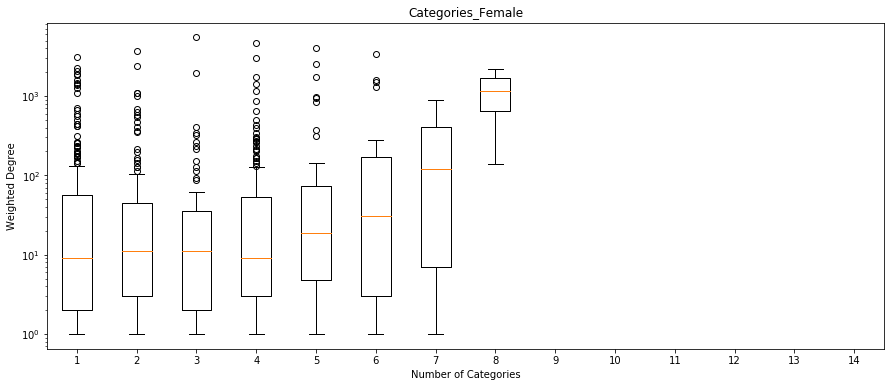

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named 'df' with the required columns
fig, ax = plt.subplots(figsize = (15, 6))
# Create a scatter plot

data=[]
for n in range(1,15):
    data.append(female_df[female_df['n_cat']==n]['Weighted Degree'])

plt.boxplot(data)

# Set plot title and labels
plt.title('Categories_Female')
plt.xlabel('Number of Categories')
plt.ylabel('Weighted Degree')
ax.set_yscale("log")

# Display the plot
plt.show()

In [70]:
# Assuming your DataFrame is named 'df'

# Filter the DataFrame to include only rows where 'n_cat' is greater than 1
filtered_df = df[df['n_cat'] > 0]

# Filter the DataFrame for rows where 'gender' is 'Female'
male_df = filtered_df[filtered_df['gender'] == 'Male']

# Calculate the number of lines in the filtered DataFrame
num_lines = len(male_df)

# Print the number of lines
print("Number of lines:", num_lines)

# Display the filtered DataFrame
display(male_df)

Number of lines: 5869


,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
9,http://ldf.fi/coco/actors/p1546073494713352697,"Adlerberg, Nikolai",politician; general; Governor-General of Finland,1892.0,1819.0,1840-01-01,1840-1899,Male,1899-12-31,Person,...,12,116,128,9,0.246907,0.272381,2687.400029,0.122222,Politics|Academia and Education|Construction|A...,6
11,http://ldf.fi/coco/actors/p3009125170449317139,"Westling, Carl Robert",captain; ensign; lieutenant colonel,1869.0,1808.0,1829-01-01,1829-1832,Male,1832-12-31,Person,...,0,2,2,11,0.159296,0.169422,0.000000,0.000000,Transportation|Military,2
50,http://ldf.fi/coco/actors/p2595496467978413262,"Krohn, Felix",conductor; composer; music teacher,1963.0,1898.0,1917-01-01,1917,Male,1917-12-31,Person,...,0,1,1,11,0.145707,0.149464,0.000000,0.000000,Academia and Education|Arts and Architecture,2
64,http://ldf.fi/coco/actors/p1445601132737583749,"Grotenfelt, Gustaf",full professor; politician; historian,1928.0,1861.0,1864-01-01,1881-1924,Male,1924-12-31,Person,...,1313,181,1494,8,0.260627,0.281394,72217.085630,0.005333,Politics|Religion|Arts and Architecture|Academ...,5
71,http://ldf.fi/coco/actors/p1233326527412107010,"Sirelius, U. T.",university teacher; full professor; director; ...,1929.0,1872.0,1900-01-01,1900-1930,Male,1930-12-31,Person,...,0,64,64,9,0.229526,0.243608,0.000000,0.188889,Business and Finance|Academia and Education|Ad...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69799,http://ldf.fi/coco/actors/p2408748848690925669,"Korhonen, Ville Vihtori",meteorologist,1958.0,1885.0,1907-01-01,1907,Male,1907-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.000000,0.000000,Academia and Education,1
69847,http://ldf.fi/coco/actors/p1996174675328768339,"Krook, Carl August",captain; intendant; major general; ensign; col...,1868.0,1811.0,1819-01-01,1836-1870,Male,1870-12-31,Person,...,89,85,174,0,0.000000,0.000000,8165.276630,0.072727,Politics|Military|Transportation|Arts and Arch...,4
69850,http://ldf.fi/coco/actors/p1454690192823649076,"Appelberg, Karl Adolf",priest; theologian,1915.0,1851.0,1895-01-01,1895-1903,Male,1903-12-31,Person,...,0,6,6,0,0.000000,0.000000,0.000000,0.333333,Religion,1
69852,http://ldf.fi/coco/actors/p9231528102370470273,"Välikangas, Ilmari",professor; biologist; ornithologist,1959.0,1884.0,1914-01-01,1914,Male,1914-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.000000,0.000000,Academia and Education,1


In [71]:
male_df[male_df['n_cat']==1]['Degree']

112       1
120       3
171       1
186      19
217       2
         ..
69793     1
69796     2
69799     1
69850     4
69852     1
Name: Degree, Length: 1809, dtype: int64

C:\Users\Tetiana\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


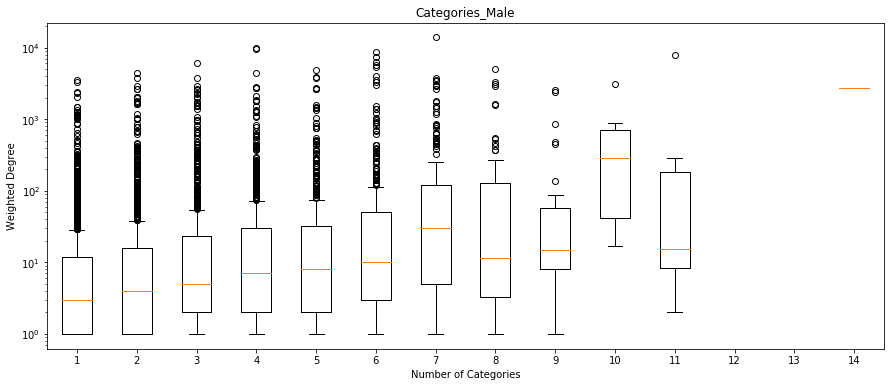

In [72]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named 'df' with the required columns
fig, ax = plt.subplots(figsize = (15, 6))
# Create a scatter plot

data=[]
for n in range(1,15):
    data.append(male_df[male_df['n_cat']==n]['Weighted Degree'])

plt.boxplot(data)

# Set plot title and labels
plt.title('Categories_Male')
plt.xlabel('Number of Categories')
plt.ylabel('Weighted Degree')
ax.set_yscale("log")

# Display the plot
plt.show()

In [49]:
filtered_df[filtered_df['n_cat']==1]['Degree']


112       1
120       3
171       1
186      19
217       2
         ..
69793     1
69796     2
69799     1
69850     4
69852     1
Name: Degree, Length: 2051, dtype: int64

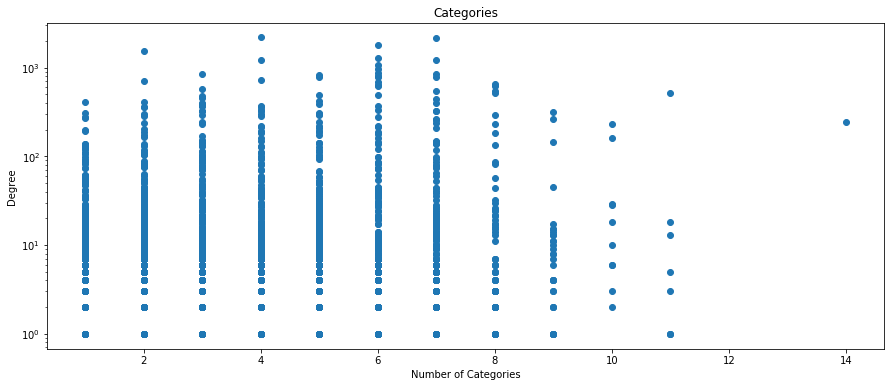

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named 'df' with the required columns
fig, ax = plt.subplots(figsize = (15, 6))
# Create a scatter plot
plt.scatter(filtered_df['n_cat'], filtered_df['Degree'])

# Set plot title and labels
plt.title('Categories')
plt.xlabel('Number of Categories')
plt.ylabel('Degree')
ax.set_yscale("log")

# Display the plot
plt.show()

C:\Users\Tetiana\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


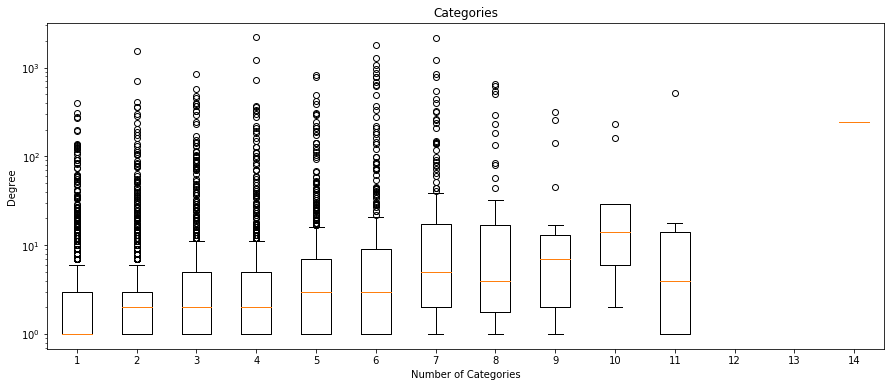

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named 'df' with the required columns
fig, ax = plt.subplots(figsize = (15, 6))
# Create a scatter plot

data=[]
for n in range(1,15):
    data.append(filtered_df[filtered_df['n_cat']==n]['Degree'])

plt.boxplot(data)

# Set plot title and labels
plt.title('Categories')
plt.xlabel('Number of Categories')
plt.ylabel('Degree')
ax.set_yscale("log")

# Display the plot
plt.show()

C:\Users\Tetiana\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


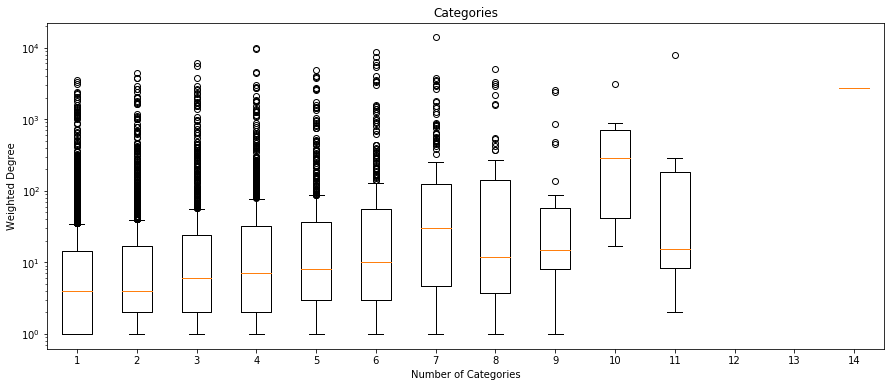

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named 'df' with the required columns
fig, ax = plt.subplots(figsize = (15, 6))
# Create a scatter plot

data=[]
for n in range(1,15):
    data.append(filtered_df[filtered_df['n_cat']==n]['Weighted Degree'])

plt.boxplot(data)

# Set plot title and labels
plt.title('Categories')
plt.xlabel('Number of Categories')
plt.ylabel('Weighted Degree')
ax.set_yscale("log")

# Display the plot
plt.show()

In [51]:
df = pd.read_csv('30_05_23.csv')
display(df)

,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
0,http://ldf.fi/coco/actors/p2380574174453621727,"Carlström, Hulda",NaN,NaN,NaN,1914-01-01,1914,Female,1914-12-31,Person,...,0,5,5,1,1.000000,1.000000,0.0,0.00,NaN,0
1,http://ldf.fi/coco/actors/p1463334693827000551,"Broman, Johan Henrik",NaN,NaN,NaN,1879-01-01,1879,Male,1879-12-31,Person,...,0,1,1,11,0.160415,0.165002,0.0,0.00,NaN,0
2,http://ldf.fi/coco/actors/p3334862743010934343,"Datta, Rena",NaN,NaN,NaN,1913-01-01,1913-1930,Female,1930-12-31,Person,...,0,9,9,1,1.000000,1.000000,0.0,0.00,NaN,0
3,http://ldf.fi/coco/actors/p3370516753270868332,"Bockström, Bertel",NaN,NaN,NaN,1898-01-01,1898,Male,1898-12-31,Person,...,0,1,1,10,0.199762,0.208582,0.0,0.00,NaN,0
4,http://ldf.fi/coco/actors/p1176606766623321549,"Ahonius, Signe",NaN,NaN,NaN,1909-01-01,1909,Female,1909-12-31,Person,...,0,1,1,10,0.197639,0.206423,0.0,0.00,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69852,http://ldf.fi/coco/actors/p9231528102370470273,"Välikangas, Ilmari",professor; biologist; ornithologist,1959.0,1884.0,1914-01-01,1914,Male,1914-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.0,0.00,"Professional, technical and related workers",0
69853,http://ldf.fi/coco/actors/p1403677916047891767,"Rosenberg, H.",NaN,NaN,NaN,1910-01-01,1910,Male,1910-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.0,0.00,NaN,0
69854,http://ldf.fi/coco/actors/p6548879634785906556,"Moberg, Adolf",full professor; rector; valtioneuvos; docent; ...,1895.0,1813.0,1845-01-01,1845-1884,Male,1884-12-31,Person,...,0,9,9,0,0.000000,0.000000,0.0,0.25,Sales workers|Administrative and managerial wo...,4
69855,http://ldf.fi/coco/actors/p1389598456547952848,"Mälkiä, A.",NaN,NaN,NaN,1917-01-01,1917,Male,1917-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.0,0.00,NaN,0


In [41]:
# Assuming you have a DataFrame named 'df_sorted' with the sorted data

# Create a new DataFrame with rows where 'n_oc' > 0
new_df = df[df['n_cat'] > 0]

# Display the new DataFrame
display(new_df)

,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
9,http://ldf.fi/coco/actors/p1546073494713352697,"Adlerberg, Nikolai",politician; general; Governor-General of Finland,1892.0,1819.0,1840-01-01,1840-1899,Male,1899-12-31,Person,...,12,116,128,9,0.246907,0.272381,2687.400029,0.122222,Administrative and managerial workers|Professi...,3
11,http://ldf.fi/coco/actors/p3009125170449317139,"Westling, Carl Robert",captain; ensign; lieutenant colonel,1869.0,1808.0,1829-01-01,1829-1832,Male,1832-12-31,Person,...,0,2,2,11,0.159296,0.169422,0.000000,0.000000,"Professional, technical and related workers|Se...",2
50,http://ldf.fi/coco/actors/p2595496467978413262,"Krohn, Felix",conductor; composer; music teacher,1963.0,1898.0,1917-01-01,1917,Male,1917-12-31,Person,...,0,1,1,11,0.145707,0.149464,0.000000,0.000000,Administrative and managerial workers|Clerical...,3
64,http://ldf.fi/coco/actors/p1445601132737583749,"Grotenfelt, Gustaf",full professor; politician; historian,1928.0,1861.0,1864-01-01,1881-1924,Male,1924-12-31,Person,...,1313,181,1494,8,0.260627,0.281394,72217.085630,0.005333,Administrative and managerial workers|Professi...,2
71,http://ldf.fi/coco/actors/p1233326527412107010,"Sirelius, U. T.",university teacher; full professor; director; ...,1929.0,1872.0,1900-01-01,1900-1930,Male,1930-12-31,Person,...,0,64,64,9,0.229526,0.243608,0.000000,0.188889,Sales workers|Administrative and managerial wo...,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69759,http://ldf.fi/coco/actors/p3267355733832740875,"Savola, Onni",actor,1957.0,1876.0,1908-01-01,1908,Male,1908-12-31,Person,...,0,1,1,0,0.000000,0.000000,0.000000,0.000000,"Professional, technical and related workers|Se...",2
69787,http://ldf.fi/coco/actors/p2124020471712616508,"Qvist, Carl Johan",vicar; priest; rural dean; chaplain; school te...,1853.0,1783.0,1844-01-01,1844,Male,1844-12-31,Person,...,1,0,1,0,0.000000,0.000000,0.000000,0.000000,Administrative and managerial workers|Professi...,3
69797,http://ldf.fi/coco/actors/p2022427054228468320,"Jusélius, Adolf",varatuomari; member of the Diet of Finland; mayor,1884.0,1814.0,1852-01-01,1852-1884,Male,1884-12-31,Person,...,99,0,99,0,0.000000,0.000000,0.000000,0.003003,Administrative and managerial workers|-1,2
69847,http://ldf.fi/coco/actors/p1996174675328768339,"Krook, Carl August",captain; intendant; major general; ensign; col...,1868.0,1811.0,1819-01-01,1836-1870,Male,1870-12-31,Person,...,89,85,174,0,0.000000,0.000000,8165.276630,0.072727,Administrative and managerial workers|Professi...,3


In [42]:
# Assuming you have a DataFrame named 'df' with a column named 'gender'

# Filter the DataFrame for rows where 'gender' is 'Female'
female_df = new_df[new_df['gender'] == 'Female']

# Display the filtered DataFrame
display(female_df)

,Id,Label,occupation,deathyear,birthyear,start_date,floruit,gender,end_date,type,...,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,clustering,Groups_per_person,n_cat
718,http://ldf.fi/coco/actors/p2518218960609204640,"Wahlroos, Dora",painter,1947.0,1870.0,1899-01-01,1899-1919,Female,1919-12-31,Person,...,0,11,11,9,0.219231,0.231437,0.000000,0.333333,"Production and related workers, transport equi...",2
768,http://ldf.fi/coco/actors/p2698243109073582234,"Albertina, Sofia",politician; art collector,1829.0,1753.0,1788-01-01,1788,Female,1788-12-31,Person,...,0,1,1,10,0.181382,0.191972,0.000000,0.000000,Administrative and managerial workers|Professi...,2
801,http://ldf.fi/coco/actors/p2536750761289783028,"Gadolin, Rubia",artist,1926.0,1903.0,1911-01-01,1911-1925,Female,1925-12-31,Person,...,11,15,26,10,0.191486,0.199595,0.000000,0.533333,"Sales workers|Professional, technical and rela...",2
964,http://ldf.fi/coco/actors/p1700197645723774845,"Sundblad, Fanny",painter; painter and varnisher,1918.0,1853.0,1872-01-01,1872-1915,Female,1915-12-31,Person,...,1,56,57,9,0.207323,0.218488,0.000000,0.089286,"Production and related workers, transport equi...",2
1159,http://ldf.fi/coco/actors/p2713583658646440551,"Lavonius, Olga",university teacher; lecturer; master's degree;...,1948.0,1876.0,1908-01-01,1908-1947,Female,1947-12-31,Person,...,0,112,112,10,0.189750,0.198186,0.000000,1.000000,"-1|Professional, technical and related workers",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67899,http://ldf.fi/coco/actors/p1836517697633732060,"Helenius, Ester",painter,1955.0,1875.0,1900-01-01,1900-1912,Female,1912-12-31,Person,...,0,10,10,0,0.000000,0.000000,0.000000,0.300000,"Production and related workers, transport equi...",2
67980,http://ldf.fi/coco/actors/p1490424798627909178,"Colerus, Ingrid",school teacher; bank teller,1963.0,1880.0,1899-01-01,1899-1936,Female,1936-12-31,Person,...,0,75,75,0,0.000000,0.000000,0.000000,0.416667,"Clerical and related workers|Professional, tec...",2
68009,http://ldf.fi/coco/actors/p2148007601060338950,"Hausen, Julia",actor,1895.0,1835.0,1856-01-01,1856-1895,Female,1895-12-31,Person,...,0,2,2,0,0.000000,0.000000,0.000000,0.000000,"Professional, technical and related workers|Se...",2
68730,http://ldf.fi/coco/actors/p1944845470208648357,"Sparre, Eva",writer; artist,1957.0,1870.0,1900-01-01,1900-1956,Female,1956-12-31,Person,...,1,23,24,0,0.000000,0.000000,0.571429,0.000000,"Sales workers|Professional, technical and rela...",2


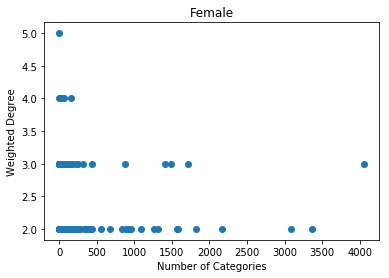

In [45]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df' with the required columns

# Create a scatter plot
plt.scatter(female_df['Weighted Degree'],female_df['n_cat'])

# Set plot title and labels
plt.title('Female')
plt.xlabel('Number of Categories')
plt.ylabel('Weighted Degree')

# Display the plot
plt.show()